# **TRIP TO <font color=red>R</font><font color=orange>A</font><font color=yellow>I</font><font color=green>N</font><font color=blue>B</font><font color=indigo>O</font><font color=violet>W</font> STATE**

-  <font color=red>**_Destination: Honolulu, HI_**</font><br>
-  <font color=green>**_Date Arrival: 2020-02-25_**</font><br>
-  <font color=violet>**_Date Departure: 2020-03-10_**</font><br>
***

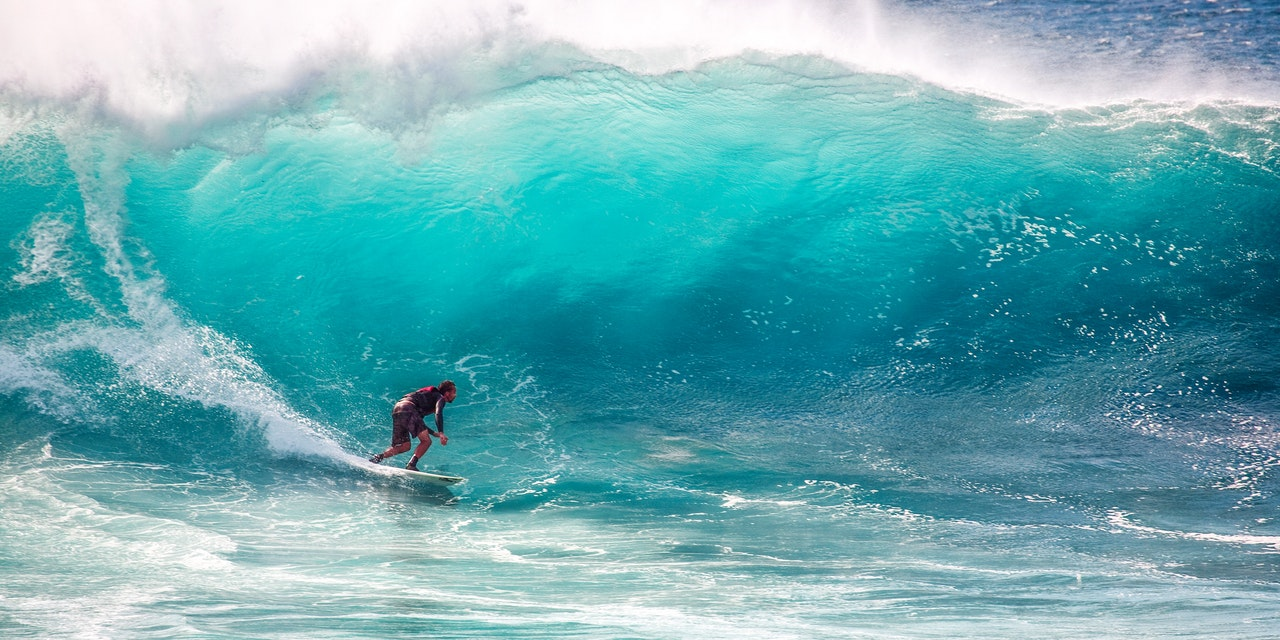

In [1]:
# Dependencies for matplotlib
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Dependencies - cont'd
import numpy as np
import pandas as pd

In [3]:
# Dependencies - cont'd
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Create the connection engine
engine = create_engine('sqlite:///Resources/hawaii.sqlite')

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create session (link) from Python to the DB
session = Session(engine)

## Exploratory Climate Analysis

### <font color=gray>**_Time Range Determination of This Dataset_**</font>

In [10]:
# Retrieve column names of "measurement" table
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [11]:
'''Determine time range of this dataset to be shown on index.html of ClimateApp'''
# Query for date of the latest documented data from "measurement" table
date_latest = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

# Query for date of the oldest documented data from "measurement" table
date_oldest = session.query(Measurement.date).order_by(Measurement.date).first()[0]

# Display time range of this dataset
print(f'Time range of this dataset is from {date_oldest} to {date_latest}.')

Time range of this dataset is from 2010-01-01 to 2017-08-23.


### <font color=gray>**_Analysis of Precipitation in the Latest 12 Months_**</font>

In [12]:
# Determine the threshold date that is exactly 1 year apart (inclusive) from "date_latest"
# Note that "dt.timedelta" automatically takes leap year into consideration
date_thold_1yr = str(dt.datetime.strptime(date_latest, "%Y-%m-%d") - dt.timedelta(days=365))[:10]

# Display one-year threshold date
print(f'One-year threshold date towards "date_latest" is {date_thold_1yr}.')

One-year threshold date towards "date_latest" is 2016-08-23.


In [13]:
# Query for ("date", "prcp") data within one-year interval from "date_latest"
prcp_1yr_retrv = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date_thold_1yr).order_by(Measurement.date).all()

# Check the length as well as the furthest date of data list retrieved
print(f'{len(prcp_1yr_retrv)} precipitation data for the latest 12 months are retrieved.')
print(f'The furthest documented date is {prcp_1yr_retrv[0][0]}.')

2230 precipitation data for the latest 12 months are retrieved.
The furthest documented date is 2016-08-23.


In [14]:
# Convert "prcp_1yr_retrv" into Pandas DataFrame and remove records with no "prcp" data
# Note that the ascending order by "date" is automatically inherited from "prcp_1yr_retrv"
prcp_df = pd.DataFrame(prcp_1yr_retrv, columns=['date', 'prcp']).dropna(how='any', subset=['prcp'])

# Set "date" column as index
prcp_df.set_index('date', inplace=True)

# Print the amount of data being saved as Pandas DataFrame
print(f'{len(prcp_df)} precipitation data are saved as Pandas DataFrame after data cleaning')

# Display a representative of "prcp_df"
prcp_df.head()

2021 precipitation data are saved as Pandas DataFrame after data cleaning


,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


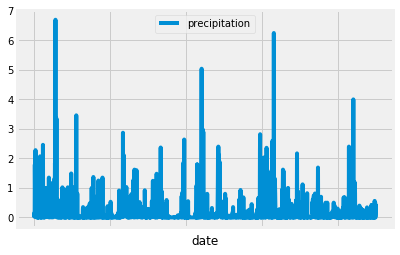

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_plt = prcp_df.plot()

# Set density of x-ticks
prcp_plt.set_xticks(np.arange(0, len(prcp_df), len(prcp_df)/4.5))

# # Set location of figure legend
prcp_plt.legend(['precipitation'], loc=9)

# Save figure
plt.savefig("Output_Data/prcp_1yr.png", dpi=300)

# Show figure
plt.show()

In [16]:
# Display the summary statistics for precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### <font color=gray>**_Station Analysis_**</font>

In [17]:
# Retrieve column names of "station" table
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

In [18]:
# Query for total number of stations in this dataset
sta_ct = session.query(Station.station).count()

# Print station counts
print(f'There are {sta_ct} stations available in this dataset.')

There are 9 stations available in this dataset.


In [19]:
# Query for stations with observation counts in descending order
sta_retrv = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Print the station with the highest number of observations
print(f'{sta_retrv[0][0]} with {sta_retrv[0][1]} observations is the most active station.')

# Display list of stations with observation counts
sta_retrv

USC00519281 with 2772 observations is the most active station.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### <font color=gray>**_Temperature Analysis for the Most Active Station_**</font>

In [20]:
# List to store arguments for temperature queries of USC00519281 station (ending with "9281")
sel_9281 = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

# Unpack "sel_9281" to query for the min, avg, and max temperature observed by USC00519281
tobs_9281_retrv = session.query(*sel_9281).filter(Measurement.station == sta_retrv[0][0]).first()

# Print out the query results
print('The lowest, average, and highest temperatures recorded by the most active station ' +\
      sta_retrv[0][0] + ' are ' + str(tobs_9281_retrv[0]) + ', '+ '%.1f' % tobs_9281_retrv[1] +\
      ', and ' + str(tobs_9281_retrv[2]) + u"\u00b0" + 'F, respectively.')

The lowest, average, and highest temperatures recorded by the most active station USC00519281 are 54.0, 71.7, and 85.0°F, respectively.


In [21]:
# Query for ("date", "tobs") data of USC00519281 within one-year interval from "date_latest"
tobs_9281_1yr_retrv = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == sta_retrv[0][0]).\
    filter(Measurement.date >= date_thold_1yr).order_by(Measurement.date).all()

# Check the length as well as the furthest date of data list retrieved
print(f'{len(tobs_9281_1yr_retrv)} temperature data recorded by the most active station'
    f' {sta_retrv[0][0]} for the latest 12 months are retrieved.')
print(f'The furthest documented date is {tobs_9281_1yr_retrv[0][0]}.')

352 temperature data recorded by the most active station USC00519281 for the latest 12 months are retrieved.
The furthest documented date is 2016-08-23.


In [22]:
# Convert "tobs_9281_1yr_retrv" into Pandas DataFrame and remove records with no "tobs" data
# Note that the ascending order by "date" is automatically inherited from "tobs_9281_1yr_retrv"
tobs_9281_df = pd.DataFrame(tobs_9281_1yr_retrv, columns=['date', 'tobs']).\
    dropna(how='any', subset=['tobs'])

# Set "date" column as index
tobs_9281_df.set_index('date', inplace=True)

# Print the amount of data being saved as Pandas DataFrame
print(f'{len(tobs_9281_df)} temperature data are saved as Pandas DataFrame after data cleaning.')

# Display a representative of "tobs_9281_df"
tobs_9281_df.head()

352 temperature data are saved as Pandas DataFrame after data cleaning.


,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0


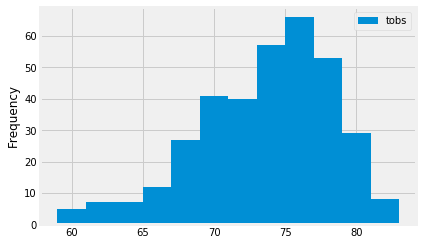

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
tobs_9281_df.plot(kind='hist', bins=12)

# Save figure
plt.savefig("Output_Data/tobs_9281.png", dpi=300)

# Show figure
plt.show()

## Climate Estimation for Planned Trip

### <font color=gray>**_Estimation of Temperature for Planned Trip_**</font>

In [24]:
# Func returns min, avg, and max temperature for given start and end date taken in '%Y-%m-%d' fmt
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    # List to store arguments for temperature queries
    sel_t = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    
    return session.query(*sel_t).filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# According to the trip plan, the arrival (arvl) and departure (dptr) dates are as follows:
date_arvl = "2020-02-25"
date_dptr = "2020-03-10"

In [26]:
# The closest data for estimation (estm) with matching months and dates are from the year 2017
date_arvl_estm = "2017-02-25"
date_dptr_estm = "2017-03-10"

In [27]:
# Calculate the min, avg, and max estimated temperature (testm) for planned trip
testm_trip = calc_temps(date_arvl_estm, date_dptr_estm)

# Print out the results
print('The lowest, average, and highest temperatures for the planned trip are estimated to be ' +\
     str(testm_trip[0][0]) + ', '+ '%.1f' % testm_trip[0][1] + ', and ' + str(testm_trip[0][2]) +\
      u"\u00b0" + 'F, respectively.')

The lowest, average, and highest temperatures for the planned trip are estimated to be 61.0, 69.9, and 78.0°F, respectively.


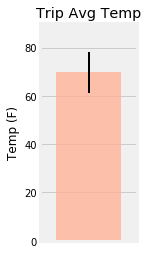

In [28]:
# Set limits of y-error (yerr) as the differences between the lowest/highest and avg temperatures
yerr_ll = [testm_trip[0][1] - testm_trip[0][0]]   # lower limit (ll)
yerr_ul = [testm_trip[0][2] - testm_trip[0][1]]   # upper limit (ul)
# Determine y-error
yerr = [yerr_ll, yerr_ul]

# Set bar as RGBA color in 0-1 range
color = (1.0, 0.7, 0.6, 0.8)

# Assign "fig" and "ax" variables for the plot
fig, ax = plt.subplots()

# Plot bar chart
# Set x and y values, bar width and color, y-error value and line width
ax.bar([1], [testm_trip[0][1]], width=4/3, color=color, yerr=yerr, error_kw=dict(lw=2))

# Set x- and y-limit
ax.set_ylim(0, 90)
ax.set_xlim(0, 2)

# Set ratio of y unit:x unit
ax.set_aspect(0.05)

# Remove x-ticks
ax.set_xticks([])

# Set density of y-ticks 
ax.yaxis.set_ticks(np.arange(0, 90, 20))

# Set y-label
ax.set_ylabel('Temp (F)')

# Set figure title
ax.set_title("Trip Avg Temp")

# Save figure
fig.savefig("Output_Data/trip_avg_temp.png", dpi=300)

# Show figure
plt.show()

### <font color=gray>**_Estimation of Precipitation per Station for Planned Trip_**</font>

In [29]:
# List to store arguments for estimated prcp queries for planned trip
sel_trip = [Station.station, Station.name, Station.latitude, Station.longitude,\
    Station.elevation, func.sum(Measurement.prcp)]

# Unpack "sel_trip" to query for station info and the total amount of prcp for planned trip
prcp_trip_retrv = session.query(*sel_trip).filter(Station.station == Measurement.station)\
    .filter(Measurement.date >= date_arvl_estm).filter(Measurement.date <= date_dptr_estm)\
    .group_by(Measurement.station).order_by(sel_trip[-1].desc()).all()

# Display "prcp_trip_retrv"
prcp_trip_retrv

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 5.89),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  5.4300000000000015),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.2),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.98),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 2.77),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  2.32),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.79)]

In [30]:
# Convert "prcp_trip_retrv" into Pandas DataFrame and remove records with no "prcp" data
# Note that the descending order by total prcp is automatically inherited from "prcp_trip_retrv"
prcp_trip_df = pd.DataFrame(prcp_trip_retrv, columns=['station', 'name', 'latitude', 'longitude',\
    'elevation', 'total_rainfall']).dropna(how='any', subset=['total_rainfall'])

# Set "station" column as index
prcp_trip_df.set_index('station', inplace=True)

# Display "prcp_trip_df"
prcp_trip_df

,name,latitude,longitude,elevation,total_rainfall
station,,,,,
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,5.89
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,5.43
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,4.20
USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.98
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2.77
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2.32
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.79


### <font color=gray>**_Estimation of Daily Normal Temperatures for Planned Trip_**</font>

In [31]:
# Func returns avg for tmin, tmax, and tavg for all historic data with month&day in "%m-%d" fmt
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    # List to store arguments for daily normal temperature queries
    sel_dn = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel_dn).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# List of months with 31 days
mon_31d = [1, 3, 5, 7, 8, 10, 12]
# List of months with 30 days
mon_30d = [4, 6, 9, 11]

# Retrieve months and days for arrival and departure dates
mon_arvl = int(date_arvl[5:7])
mon_dptr = int(date_dptr[5:7])
day_arvl = int(date_arvl[8:])
day_dptr = int(date_dptr[8:])

# List to store trip dates in Honolulu, HI 
trip_dates = []

# Check if trip is scheduled in a single month and if true ...
if mon_arvl == mon_dptr:
    # Concatenate days from arrival to departure with year and month info, append to "trip_dates"
    for i in range(day_arvl, day_dptr + 1):
        # Add string "0" to date string if less than 10
        if i < 10:
            add_zero = '0'
        else:
            add_zero = ''
        trip_dates.append(date_arvl[:8] + add_zero + str(i))
# If departure date is in the next month of that for arrival
# Note that the trip takes 3-15 days, the arrival date is greater than 10 in this scenario
else:
    # Determine the maximum range number for day iteration
    if mon_arvl in mon_31d:
        day_range_max = 32
    else:
        if mon_arvl in mon_30d:
            day_range_max = 31
        # Arrival month is February
        else:
            # The four-digits of year info from the leap year can be divided by 4
            if int(date_arvl[:4]) % 4 == 0:
                day_range_max = 30
            else:
                day_range_max = 29
        
    # Loop from arrival day to the end of arrival month
    for i in range(day_arvl, day_range_max):
        # Concatenate iterated days with arrival year and month, append to "trip_dates" 
        trip_dates.append(date_arvl[:8] + str(i))
    # Continue to loop from the first to the departure day of departure month
    for i in range(1, day_dptr + 1):
        # Add string "0" to date string if less than 10
        if i < 10:
            add_zero = '0'
        else:
            add_zero = ''
        trip_dates.append(date_dptr[:8] + add_zero + str(i))

# Display dates of planned trip
trip_dates

['2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10']

In [33]:
# List to store daily normal temperatures for trip dates in Honolulu, HI
normals = []

# Calculate daily normal temperatures for months and dates matching that of trip
[normals.append(daily_normals(date[5:])) for date in trip_dates]

# Display daily normal temperatures
normals

[[(61.0, 68.59649122807018, 76.0)],
 [(62.0, 69.89285714285714, 78.0)],
 [(58.0, 69.98148148148148, 77.0)],
 [(65.0, 70.65517241379311, 80.0)],
 [(67.0, 71.73333333333333, 79.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)],
 [(60.0, 69.20338983050847, 76.0)],
 [(60.0, 69.17241379310344, 78.0)],
 [(59.0, 68.72413793103448, 78.0)],
 [(57.0, 68.56140350877193, 75.0)],
 [(57.0, 69.12280701754386, 75.0)]]

In [34]:
# Lists to store tmin, tavg, and tmax of daily normal temperatures for trip dates
tmin_nor = []
tavg_nor = []
tmax_nor = []

# Append tmin, tavg, and tmax data to corresponding lists
for i in range(len(trip_dates)):
    tmin_nor.append(normals[i][0][0])
    tavg_nor.append(round(normals[i][0][1], 1))
    tmax_nor.append(normals[i][0][2])

In [35]:
# Create a Pandas DataFrame to store daily normal temperatures (tnor)of trip dates
tnor_trip_df = pd.DataFrame(
    {"date": trip_dates,
     "tmin": tmin_nor,
     "tavg": tavg_nor,
     "tmax": tmax_nor    
    })

# Set "date" column as index
tnor_trip_df.set_index('date', inplace=True)

# Display "tnor_trip_df"
tnor_trip_df

,tmin,tavg,tmax
date,,,
2020-02-25,61.0,68.6,76.0
2020-02-26,62.0,69.9,78.0
2020-02-27,58.0,70.0,77.0
2020-02-28,65.0,70.7,80.0
2020-02-29,67.0,71.7,79.0
2020-03-01,64.0,70.0,76.0
2020-03-02,61.0,70.4,78.0
2020-03-03,60.0,70.1,78.0
2020-03-04,57.0,69.3,77.0


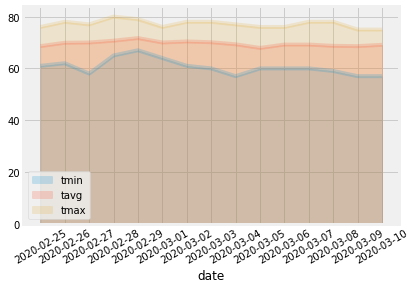

In [36]:
# Set x- and y-ticks
xtks = np.arange(len(trip_dates))
ytks = np.arange(0, 85, 20)

# Use Pandas Plotting with Matplotlib to plot the data
tnor_trip_df.plot(kind='area', xticks=xtks, yticks=ytks, rot=30, stacked=False, alpha=0.2)

# Save figure
plt.savefig("Output_Data/daily_normal_temperature.png", dpi=300)

# Show figure
plt.show()

## Remove Session from DB

In [37]:
# Close Session(engine)
session.close()